In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [2]:
ISEAR_dataset = pd.read_csv('G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ISEAR csv\ISEAR.csv')
ISEAR_dataset.dropna(axis=1, how="any", thresh=None, subset=None, inplace=True)
ISEAR_dataset = ISEAR_dataset[ISEAR_dataset.emotion != 'disgust']
ISEAR_dataset = ISEAR_dataset[ISEAR_dataset.emotion != 'shame']
ISEAR_dataset = ISEAR_dataset[ISEAR_dataset.emotion != 'guilt']
ISEAR_dataset = ISEAR_dataset[["sentence", "emotion"]]
ISEAR_dataset = ISEAR_dataset.rename(columns={'sentence':'text','emotion':'label'})
ISEAR_dataset.groupby(['label']).count()

,text
label,
anger,1079
fear,1076
joy,1092
sadness,1082


In [3]:
for index, row in ISEAR_dataset.iterrows():
    row["text"] = row["text"].strip().replace("   "," ").replace("  "," ").replace("\n","")

In [4]:
ISEAR_train = ISEAR_dataset[0: int(0.8*len(ISEAR_dataset))]
ISEAR_val = ISEAR_dataset[int(0.8*len(ISEAR_dataset)):int(0.9*len(ISEAR_dataset))]
ISEAR_test = ISEAR_dataset[int(0.9*len(ISEAR_dataset)):]

In [5]:
print(ISEAR_train)

                                                   text    label
0     On days when I feel close to my partner and ot...      joy
1     Every time I imagine that someone I love or I ...     fear
2     When I had been obviously unjustly treated and...    anger
3     When I think about the short time that we live...  sadness
7     After my girlfriend had taken her exam we went...      joy
...                                                 ...      ...
6001  I felt angry when repeated pleas to the ticket...    anger
6002  I am filled with gloom and sadness at the deat...  sadness
6006  When India first won the world cup cricket tou...      joy
6007  I was then in the 10th standard and was going ...     fear
6008  I was travelling from Delhi to Bombay. I had b...    anger

[3463 rows x 2 columns]


In [6]:
from datasets import load_dataset
dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\valsa\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset.set_format(type="pandas")
train = dataset["train"][:]
test = dataset["test"][:]
val = dataset["validation"][:]

In [8]:
# train = train[train.label != 2]
# train = train[train.label != 5]
frames = [ISEAR_train, train]
train = pd.concat(frames)
train = train.reset_index(drop=True)

# test = test[test.label != 2]
# test = test[test.label != 5]
frames = [ISEAR_test, test]
test = pd.concat(frames)
test = test.reset_index(drop=True)

# val = val[val.label != 2]
# val = val[val.label != 5]
frames = [ISEAR_val, val]
val = pd.concat(frames)
val = val.reset_index(drop=True)

In [9]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    labels = labels.replace([0,1,2,3,4,5],['sadness','joy','love','anger','fear','surprise'])
    return tweets, labels

In [10]:
tweets, labels = get_tweet(train)

In [11]:
print(train)

                                                    text    label
0      On days when I feel close to my partner and ot...      joy
1      Every time I imagine that someone I love or I ...     fear
2      When I had been obviously unjustly treated and...    anger
3      When I think about the short time that we live...  sadness
4      After my girlfriend had taken her exam we went...      joy
...                                                  ...      ...
19458  i just had a very brief time in the beanbag an...        0
19459  i am now turning and i feel pathetic that i am...        0
19460                     i feel strong and good overall        1
19461  i feel like this was such a rude comment and i...        3
19462  i know a lot but i feel so stupid because i ca...        0

[19463 rows x 2 columns]


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [14]:
tokenizer.texts_to_sequences([tweets[1]])

[[168, 45, 2, 946, 10, 136, 2, 89, 38, 2, 83, 1213, 7, 1241, 1145, 80, 344]]

In [15]:
tweets[1]

'Every time I imagine that someone I love or I could contact a serious illness, even death.'

<function matplotlib.pyplot.show(close=None, block=None)>

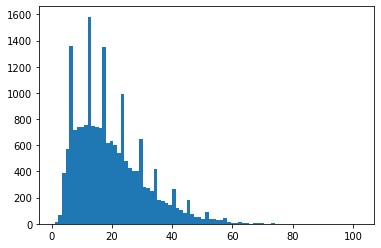

In [16]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [17]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [19]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [20]:
padded_train_seq

array([[ 30, 157,  17, ...,   0,   0,   0],
       [168,  45,   2, ...,   0,   0,   0],
       [ 17,   2,  32, ...,   0,   0,   0],
       ...,
       [  2,   4, 370, ...,   0,   0,   0],
       [  2,   4,  18, ...,   0,   0,   0],
       [  2,  53,   7, ...,   0,   0,   0]])

In [21]:
classes = set(labels)
print(classes)

{'anger', 'joy', 'sadness', 'fear', 'love', 'surprise'}


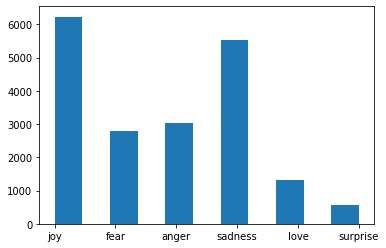

In [22]:
plt.hist(labels, bins=11)
plt.show()

In [23]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [24]:
class_to_index

{'anger': 0, 'joy': 1, 'sadness': 2, 'fear': 3, 'love': 4, 'surprise': 5}

In [25]:
index_to_class

{0: 'anger', 1: 'joy', 2: 'sadness', 3: 'fear', 4: 'love', 5: 'surprise'}

In [26]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [27]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


In [28]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(.25, input_shape=(2,)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 301,062
Trainable params: 301,062
Non-trainable params: 0
_________________________________________________________________


In [30]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [31]:
val_tweets[0], val_labels[0]

('The news of the natural calamity, an earthquake in which hundreds of Mexican people died.',
 2)

In [32]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=30,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/30
609/609 [==============================] - 19s 18ms/step - loss: 1.2076 - accuracy: 0.5043 - val_loss: 0.7361 - val_accuracy: 0.7119
Epoch 2/30
609/609 [==============================] - 10s 16ms/step - loss: 0.5156 - accuracy: 0.8178 - val_loss: 0.4272 - val_accuracy: 0.8594
Epoch 3/30
609/609 [==============================] - 10s 16ms/step - loss: 0.3016 - accuracy: 0.8984 - val_loss: 0.3570 - val_accuracy: 0.8738
Epoch 4/30
609/609 [==============================] - 10s 16ms/step - loss: 0.2191 - accuracy: 0.9241 - val_loss: 0.4168 - val_accuracy: 0.8693
Epoch 5/30
609/609 [==============================] - 10s 16ms/step - loss: 0.1705 - accuracy: 0.9411 - val_loss: 0.4018 - val_accuracy: 0.8660


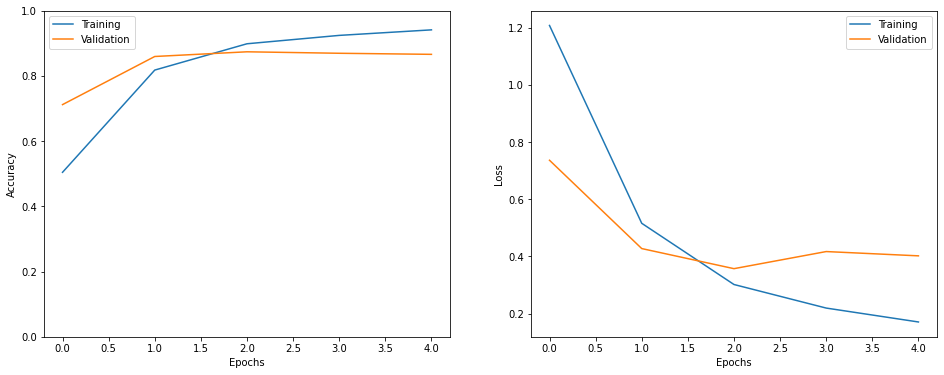

In [33]:
show_history(h)

In [34]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [35]:
_=model.evaluate(test_seq, test_labels)

77/77 [==============================] - 1s 7ms/step - loss: 0.4690 - accuracy: 0.8376


In [36]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel sorta vain
Emotion: sadness
Predicted Emotion: sadness


In [37]:
preds = np.argmax(model.predict(test_seq), axis=-1)

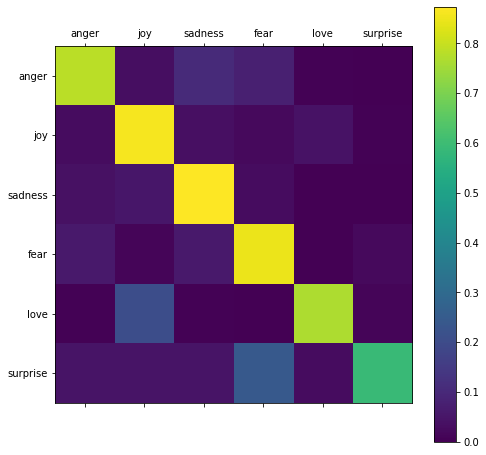

In [38]:
show_confusion_matrix(test_labels, preds, list(classes))

In [39]:
from datetime import datetime
model.save("C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/SA_Model_Final_{}".format(datetime.now().strftime("%d%m%Y_%H_%M_%S")))

INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/SA_Model_Final_05012022_10_28_19\assets


INFO:tensorflow:Assets written to: C:/Users/valsa/OneDrive - The University of the West Indies, St. Augustine/Final Year/ECNG 3020/Python Scripts/SA_Model_Final_05012022_10_28_19\assets
